In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os.path as path
from scipy.stats import beta
from matplotlib import pyplot as plt

DATASETS_PATH = path.join("datasets", "balanced_exposure")

# Probability of sharing distribution


## Description of the model and the data

They consider two groups, $A$ and $B$, and two campaigns (which are roughly equivalent to our articles $a$ and $b$).

Articles $a$ and $b$ propagate independently of each other: $u_2$ shares article $a$ with probability $p_A$, given that $u_1$ shared it. Analogously, $u_2$ shares article $b$ with probability $p_B$, given that $u_1$ shared it.

They model the spread of information with a graph where a subset of the nodes are seeded with the information.

In this dataset, the graph is the Twitter's follower graph (an edge conveys that $u_2$ follows $u_1$). The dataset also contains the probabilities $p_A$ and $p_B$.

We only know the group for the seeds in the graph.

We perform the analysis for the following datasets in the dataset of "*Balancing Information Exposure in Social Networks*".

- [uselections](#uselections)
- [brexit](#brexit)
- [abortion](#abortion)
- [obamacare](#obamacare)

In [2]:
if not path.isdir('datasets'):
    !./get_datasets.sh

## uselections

In [3]:
# load seeds
USELEC_PATH = path.join(DATASETS_PATH, 'uselections')
A = [l.strip() for l in open(path.join(USELEC_PATH, "side1_seeds.txt")).readlines()]  # A = pro Hillary
B = [l.strip() for l in open(path.join(USELEC_PATH, "side2_seeds.txt")).readlines()]  # B = pro Trump
len(A), len(B)

(85, 99)

In [4]:
# load probabilities
df = pd.read_csv(path.join(USELEC_PATH, "uselections_network_heterogeneous.txt"), sep='\t', names=['User', 'Follower', 'Pa', 'Pb'])
df

,User,Follower,Pa,Pb
0,003a04f8c2054b7,birdonachair,0.000834,0.008674
1,003a04f8c2054b7,patriot18d,0.001160,0.003320
2,003a04f8c2054b7,pamela_moore13,0.000143,0.004143
3,003a04f8c2054b7,jbaker31826004,0.000604,0.015884
4,003a04f8c2054b7,glucklichschon,0.001960,0.019880
...,...,...,...,...
845147,healthyyoga07,rickrwells,0.000250,0.010810
845148,healthyyoga07,supercos7,0.004560,0.015920
845149,healthyyoga07,ladiesfortrump,0.001448,0.032888
845150,healthyyoga07,usa_with_trump,0.001067,0.016427


#### Issues with the dataset:

In [5]:
df.groupby('Follower').std().sort_values('Pa', ascending=False)

,Pa,Pb
Follower,,
003a04f8c2054b7,0.0,0.0
ohiorepubmom,0.0,0.0
officecandy,0.0,0.0
officialtrumpil,0.0,0.0
offthemenu67,0.0,0.0
...,...,...
zoso418,NaN,NaN
ztrak5050,NaN,NaN
zuivercor,NaN,NaN


Surprisingly, there is zero variance in the probabilities of sharing within a follower (if we fix User2 all the probabilities are the same). This is strange because to estimate these probabilities they divide posts that $u_2$ shared from $u_1$ divided by total posts shared by $u_2$. This would imply that all users shared the same number of posts from the people they follow!?

I opened an issue in their GitHub:

https://github.com/gvrkiran/BalancedExposure/issues/1

### Homophily

We measure homophily by estimating the probabilities that a user that belongs to group $g$ follows a user in group $g'$. This is very close to our replacement model because if $u_1$ shares content, it gives the opportunity to $u_2$ (the follower) to retweet the content.

In [6]:
# membership
labeled = df[(df.User.isin(A) | df.User.isin(B)) & (df.Follower.isin(A) | df.Follower.isin(B))].copy()
labeled['Group1'] = labeled.User.isin(A).replace({True: 'A', False: 'B'})
labeled['Group2'] = labeled.Follower.isin(A).replace({True: 'A', False: 'B'})
labeled.head()

,User,Follower,Pa,Pb,Group1,Group2
3282,1boxingking1,georgemason101,0.003017,0.082857,B,B
6861,20donaldtrump16,azz_amis,0.006907,0.086667,B,B
6865,20donaldtrump16,tukinovf,0.002937,0.082857,B,B
6870,20donaldtrump16,ronyerby,0.004160,0.084000,B,B
11871,6f1abe900f56450,honey17011,0.065718,0.000518,A,A


In [7]:
labeled.to_csv('edge_list2.csv', index=False)

In [8]:
labeled.Group1.value_counts(normalize=True).rename("$\\pi$").reset_index()

,index,$\pi$
0,A,0.554237
1,B,0.445763



To estimate the $q$ probabilities we just count the number of edges for each combination of groups and calculate group frequencies.

In [9]:
# replacement counts
replacements = (labeled.groupby(['Group1', 'Group2']).User
                       .count()
                       .unstack(fill_value=0)
                       .stack()
                       .rename('Counts')
                       .reset_index()
                       .set_index(['Group1', 'Group2']))
replacements

Counts
Group1 Group2        
A      A          323
       B            4
B      A            0
       B          263

In [10]:
# group1 counts
groups = (labeled.groupby('Group1').User
                 .count()
                 .rename('Counts')
                 .reset_index()
                 .set_index('Group1'))
groups

,Counts
Group1,
A,327
B,263


In [11]:
qs = (replacements / groups).rename(columns={'Counts': 'Frequency ($q$)'})
qs

Frequency ($q$)
Group1 Group2                 
A      A              0.987768
       B              0.012232
B      A              0.000000
       B              1.000000

The following is the homophily matrix (coordinates are the $q_A$, $1-q_A$, and 1- $q_B$, $q_B$ probabilities):

In [12]:
qs.unstack().values

array([[0.98776758, 0.01223242],
       [0.        , 1.        ]])

### Share probability distributions


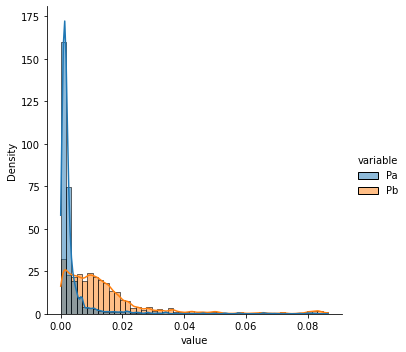

In [13]:
sns.displot(data=pd.melt(df,
                         id_vars=['User', 'Follower'],
                         value_vars=['Pa', 'Pb']),
            x='value',
            hue='variable',
            bins=50, kde=True, stat='density')

The pro-Trump distribution ($p_b$) is less skewed, meaning that pro-Trump tweets are more likely to be retweeted.

Since this is a distribution of probabilities, it should have support on $[0,1]$. A beta distribution may be a good choice to fit the data.

In [14]:
# MLE estimates for the parameters of the beta distribution (for P_a)
a1, b1, loc1, scale1 = beta.fit(df.Pa, floc=0, fscale=1)
a1, b1

(0.7961640748261505, 222.62377495491623)

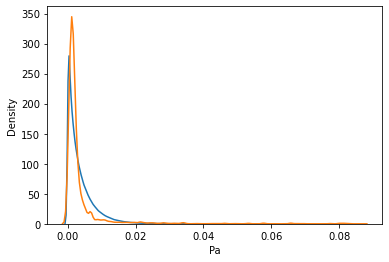

In [15]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=df.Pa.shape[0]))
sns.kdeplot(df.Pa)

In [16]:
# MLE estimates for the parameters of the beta distribution (for p_B)
a2, b2, loc2, scale2 = beta.fit(df.Pb, floc=0, fscale=1)
a2, b2

(1.0402128477517107, 71.47304220053908)

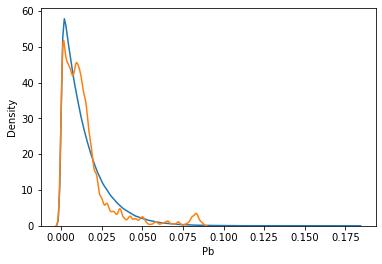

In [17]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=df.Pb.shape[0]))
sns.kdeplot(df.Pb)

The probabilities above are the conditional probabilities on a given initiator. In the data we see that the probability of sharing is independent of the initiator. That's strange because, in practice, since reputation and credibility are important factors for sharing someone else's tweet.

### Different groups

Ideally, we would like to study the distributions of $p_{A, s}$ and $p_{B, s}$ for $s\in\{a,b\}$ and not just the marginal probabilities $p_{*, a}$ and $p_{*,b}$ (which are the probabilities of clicking on the articles regardless of group membership).

In [18]:
dfg = df[df.Follower.isin(B) | df.Follower.isin(A)]  # we just care about the group of the user who is retweeting

In [19]:
group = dfg.Follower.isin(A).replace({True: 'A', False: 'B'})

In [20]:
dfg.groupby(group).Follower.count()

Follower
A    6692
B    8765
Name: Follower, dtype: int64

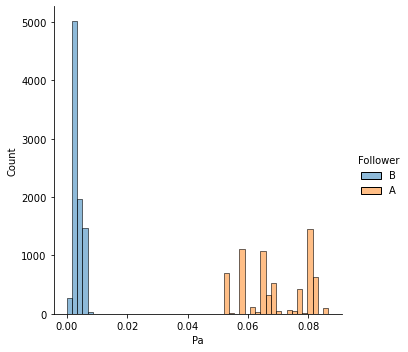

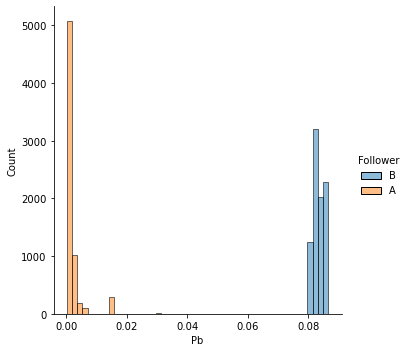

In [21]:
sns.displot(data=dfg, x='Pa', hue=group, bins=50)
sns.displot(data=dfg, x='Pb', hue=group, bins=50)

This symmetry makes sense because the probability of sharing the article that agrees with the group's views is higher than otherwise.

#### Fitting the distribution of $p_{A,a}$

In [22]:
# MLE estimates for the parameters of the beta distribution (for $p_{A,a}$)
a1, b1, loc1, scale1 = beta.fit(dfg[group == 'A'].Pa, floc=0, fscale=1)
a1, b1

(41.45784070052453, 556.8653671739492)

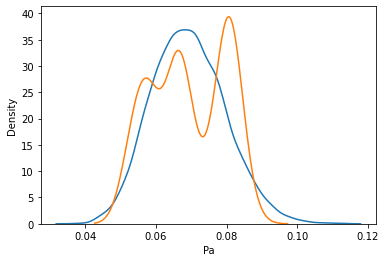

In [23]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=dfg[group == 'A'].Pa.shape[0]))
sns.kdeplot(dfg[group == 'A'].Pa, bw_adjust=2)

#### Fitting the distribution of $p_{A,b}$

In [24]:
a2, b2, loc2, scale2 = beta.fit(dfg[group == 'A'].Pb, floc=0, fscale=1)
a2, b2

(0.7519296311195025, 413.4664888783973)

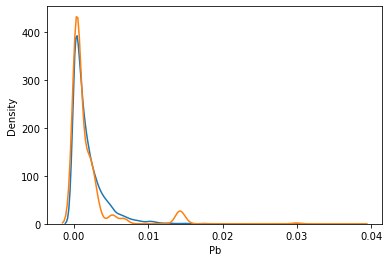

In [25]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=dfg[group == 'A'].Pb.shape[0]))
sns.kdeplot(dfg[group == 'A'].Pb)

#### Fitting the distribution of $p_{B,a}$

In [26]:
a3, b3, loc3, scale3 = beta.fit(dfg[group == 'B'].Pa, floc=0, fscale=1)
a3, b3

(6.096475779403813, 1519.8459882514462)

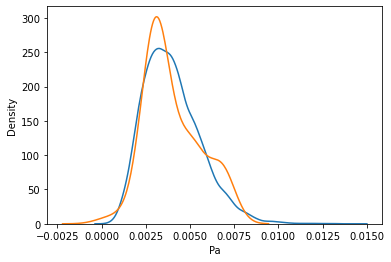

In [27]:
sns.kdeplot(np.random.beta(a=a3, b=b3, size=dfg[group == 'B'].Pa.shape[0]))
sns.kdeplot(dfg[group == 'B'].Pa, bw_adjust=3)

#### Fitting the distribution of $p_{B,b}$

In [28]:
a4, b4, loc4, scale4 = beta.fit(dfg[group == 'B'].Pb, floc=0, fscale=1)
a4, b4

(2152.960173995409, 23647.671142918956)

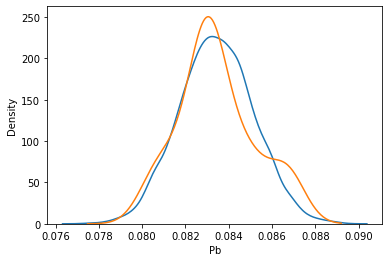

In [29]:
sns.kdeplot(np.random.beta(a=a4, b=b4, size=dfg[group == 'B'].Pb.shape[0]))
sns.kdeplot(dfg[group == 'B'].Pb, bw_adjust=3)

In [30]:
# TODO: perhaps we should perform some goodness-of-fit tests

### Propagation of the articles

In [31]:
COLS = ['k', 'i', 'num_players']

def propagate(seeds, article='a', steps=300, runs=20):
    '''Yields the people that are exposed on each time-step of the propagation.
    
    Simulates the propagation of an article by 
    '''
    if article not in ['a', 'b']:
        raise ValueError('Wrong argument: valid articles are either `a` or `b`.')
        
    for k in range(runs):
        # first users to be exposed are the seeds
        exposed = df[df.User.isin(seeds)].copy()
        for i in range(steps):
            # the generator returns the number of people exposed to the article
            yield k, i, len(exposed)
            
            # toss a coin for each exposed user to determine whether or not they share the article
            sharing_probs = exposed.Pa if article == 'a' else exposed.Pb
            shares = np.random.binomial(1, p=sharing_probs)
            
            # the new generation of users are the followers of those who shared it:
            newgen = set(exposed[shares.astype(bool)].Follower.tolist())
            
            # set exposed list to followers
            exposed = df[df.User.isin(newgen)].copy()

In [32]:
# measure propagation of article a among A
propAa = pd.DataFrame(propagate(A, article='a'), columns=COLS)

# measure propagation of article b among B
propBb = pd.DataFrame(propagate(B, article='b'), columns=COLS)

# measure propagation of article b among A
propAb = pd.DataFrame(propagate(A, article='b'), columns=COLS)

# measure propagation of article a among B
propBa = pd.DataFrame(propagate(B, article='a'), columns=COLS)

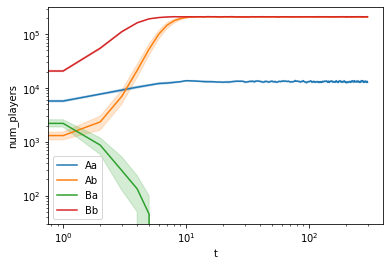

In [33]:
g = sns.lineplot(x='i', y='num_players', data=propAa)
sns.lineplot(x='i', y='num_players', data=propAb)
sns.lineplot(x='i', y='num_players', data=propBa)
sns.lineplot(x='i', y='num_players', data=propBb)
g.set_yscale("log")
g.set_xscale("log")
g.legend(['Aa', 'Ab', 'Ba', 'Bb'])
g.set(xlabel='t')

plt.savefig('../figures/uselections.pdf', format='pdf', dpi=1200)

## brexit

In [103]:
# load seeds
BREXIT_PATH = path.join(DATASETS_PATH, 'brexit')
A = [l.strip() for l in open(path.join(BREXIT_PATH, "side1_seeds.txt")).readlines()]  # A = remainers
B = [l.strip() for l in open(path.join(BREXIT_PATH, "side2_seeds.txt")).readlines()]  # B = brexiters
len(A), len(B)

(60, 94)

In [104]:
# load probabilities
df = pd.read_csv(path.join(BREXIT_PATH, "brexit_network_heterogeneous.txt"),
                 sep='\t', names=['User', 'Follower', 'Pa', 'Pb'])
df

,User,Follower,Pa,Pb
0,007harvey,spanks69,3.200200e-04,9.600200e-04
1,007harvey,leon19070210,1.440020e-03,1.200002e-02
2,007harvey,kiwikafir,9.600200e-04,2.400020e-03
3,007harvey,countryboylife,4.800200e-04,2.000000e-08
4,007harvey,izzydos,2.000000e-08,2.000000e-08
...,...,...,...,...
48825,leavehq,stop_the_eu,4.800200e-04,8.000002e-02
48826,leavehq,andreww01447528,3.200200e-04,3.200020e-03
48827,leavehq,karrider,2.000000e-08,2.000000e-08
48828,leavehq,peter_woods,5.280020e-03,6.432002e-02


In [105]:
((df.groupby('Follower')
    .std().dropna() > 0).value_counts(normalize=True)
                        .rename("% std > 0")
                        .reset_index())

,Pa,Pb,% std > 0
0,False,False,0.716838
1,True,True,0.283162


It seems that this dataset does not have the issue we found in the uselections dataset, yet 72% of the followers have the same probability of sharing across all the people they follow.

### Homophily

We measure homophily by estimating the probabilities that a user that belongs to group $g$ follows a user in group $g'$. This is very close to our replacement model because if $u_1$ shares content, it gives the opportunity to $u_2$ (the follower) to retweet the content.

In [106]:
# membership
labeled = df[(df.User.isin(A) | df.User.isin(B)) & (df.Follower.isin(A) | df.Follower.isin(B))].copy()
labeled['Group1'] = labeled.User.isin(A).replace({True: 'A', False: 'B'})
labeled['Group2'] = labeled.Follower.isin(A).replace({True: 'A', False: 'B'})
labeled.head()

,User,Follower,Pa,Pb,Group1,Group2
1328,_ilbtm,steven_winstone,0.01104,0.00592,A,A
1329,_ilbtm,sj_powell,0.01856,0.08000,A,A
1333,_ilbtm,politicssense,0.01200,0.01312,A,A
1341,_ilbtm,theordinaryman2,0.08000,0.08000,A,A
1346,_ilbtm,stop_the_eu,0.00048,0.08000,A,B


In [107]:
labeled.Group1.value_counts(normalize=True).rename("$\\pi$").reset_index()

,index,$\pi$
0,A,0.524684
1,B,0.475316


In [108]:
labeled.groupby('Follower').count().reset_index().merge(labeled, on='Follower').groupby('Group2_y').mean()

,User_x,Pa_x,Pb_x,Group1_x,Group2_x,Pa_y,Pb_y
Group2_y,,,,,,,
A,20.070671,20.070671,20.070671,20.070671,20.070671,0.025409,0.053670
B,15.413115,15.413115,15.413115,15.413115,15.413115,0.004324,0.072538



To estimate the $q$ probabilities we just count the number of edges for each combination of groups and calculate group frequencies.

In [109]:
# replacement counts
replacements = (labeled.groupby(['Group1', 'Group2']).User
                       .count()
                       .unstack(fill_value=0)
                       .stack()
                       .rename('Counts')
                       .reset_index()
                       .set_index(['Group1', 'Group2']))
replacements

Counts
Group1 Group2        
A      A          311
       B          146
B      A          255
       B          159

In [110]:
# group1 counts
groups = (labeled.groupby('Group1').User
                 .count()
                 .rename('Counts')
                 .reset_index()
                 .set_index('Group1'))
groups

,Counts
Group1,
A,457
B,414


In [111]:
qs = (replacements / groups).rename(columns={'Counts': 'Frequency ($q$)'})
qs

Frequency ($q$)
Group1 Group2                 
A      A              0.680525
       B              0.319475
B      A              0.615942
       B              0.384058

It seems that the pro-brexit group does not have homophily. @Jessie says this could be due to the demographics of the group, which is mostly very old people compared to the other group.

The following is the homophily matrix (coordinates are the $q_A$, $1-q_A$, and 1- $q_B$, $q_B$ probabilities):

In [112]:
qs.unstack().values

array([[0.68052516, 0.31947484],
       [0.61594203, 0.38405797]])

### Share probability distributions


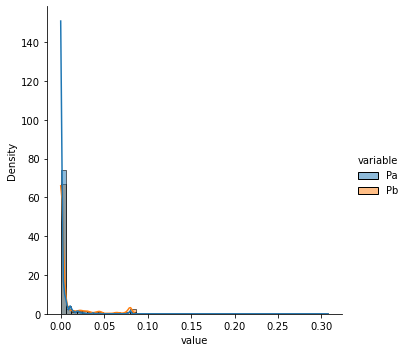

In [113]:
sns.displot(data=pd.melt(df,
                         id_vars=['User', 'Follower'],
                         value_vars=['Pa', 'Pb']),
            x='value',
            hue='variable',
            bins=50, kde=True, stat='density')

In comparison to the uselections dataset, in brexit both sharing distributions are very skewed.

In [114]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a1, b1, loc1, scale1 = beta.fit(df.Pa, floc=0, fscale=1)
a1, b1

(0.12045986525314124, 51.07492424881336)

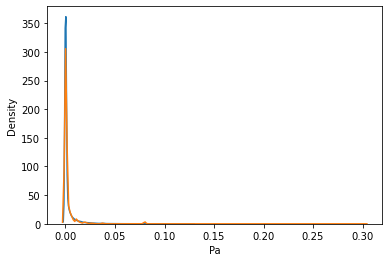

In [115]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=df.Pa.shape[0]))
sns.kdeplot(df.Pa)

In [116]:
# MLE estimates for the parameters of the beta distribution (for p_B)
a2, b2, loc2, scale2 = beta.fit(df.Pb, floc=0, fscale=1)
a2, b2

(0.11460151200225399, 14.595024591908238)

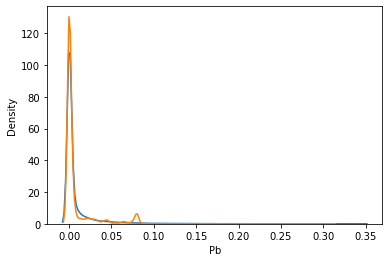

In [117]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=df.Pb.shape[0]))
sns.kdeplot(df.Pb)

### Different groups


In [118]:
dfg = df[df.Follower.isin(B) | df.Follower.isin(A)]  # we just care about the group of the user who is retweeting

In [119]:
group = dfg.Follower.isin(A).replace({True: 'A', False: 'B'})

In [120]:
dfg.groupby(group).Follower.count()

Follower
A    3008
B    1392
Name: Follower, dtype: int64

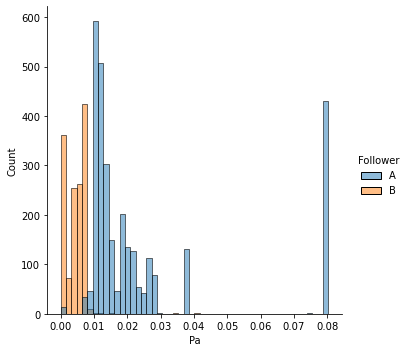

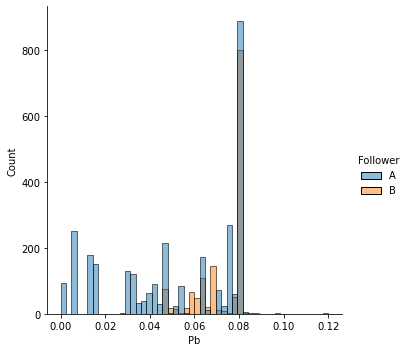

In [121]:
sns.displot(data=dfg, x='Pa', hue=group, bins=50)
sns.displot(data=dfg, x='Pb', hue=group, bins=50)

#### Fitting the distribution of $p_{A,a}$

In [122]:
# MLE estimates for the parameters of the beta distribution (for $p_{A,a}$)
a1, b1, loc1, scale1 = beta.fit(dfg[group == 'A'].Pa, floc=0, fscale=1)
a1, b1

(1.6421893317945877, 62.9176081976947)

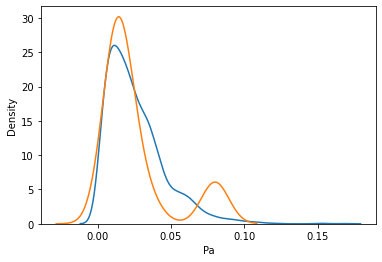

In [123]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=dfg[group == 'A'].Pa.shape[0]))
sns.kdeplot(dfg[group == 'A'].Pa, bw_adjust=2)

#### Fitting the distribution of $p_{A,b}$

In [124]:
a2, b2, loc2, scale2 = beta.fit(dfg[group == 'A'].Pb, floc=0, fscale=1)
a2, b2

(1.4779704026249152, 27.402822213177515)

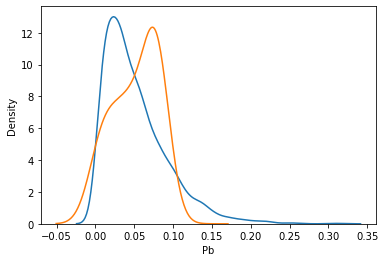

In [125]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=dfg[group == 'A'].Pb.shape[0]))
sns.kdeplot(dfg[group == 'A'].Pb, bw_adjust=3)

#### Fitting the distribution of $p_{B,a}$

In [126]:
a3, b3, loc3, scale3 = beta.fit(dfg[group == 'B'].Pa, floc=0, fscale=1)
a3, b3

(1.7187375537951832, 380.1479381108044)

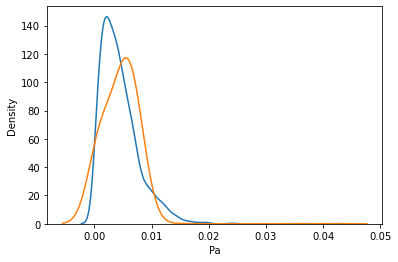

In [127]:
sns.kdeplot(np.random.beta(a=a3, b=b3, size=dfg[group == 'B'].Pa.shape[0]))
sns.kdeplot(dfg[group == 'B'].Pa, bw_adjust=3)

#### Fitting the distribution of $p_{B,b}$

In [128]:
a4, b4, loc4, scale4 = beta.fit(dfg[group == 'B'].Pb, floc=0, fscale=1)
a4, b4

(39.62421666552372, 506.9074863422272)

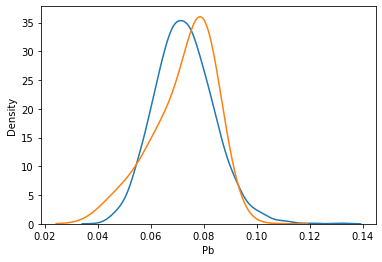

In [129]:
sns.kdeplot(np.random.beta(a=a4, b=b4, size=dfg[group == 'B'].Pb.shape[0]))
sns.kdeplot(dfg[group == 'B'].Pb, bw_adjust=3)

## Propagation of the articles

In [130]:
cols = ['k', 'i', 'num_players']

# measure propagation of article a among A
propAa = pd.DataFrame(propagate(A, article='a'), columns=cols)

# measure propagation of article b among B
propBb = pd.DataFrame(propagate(B, article='b'), columns=cols)

# measure propagation of article b among A
propAb = pd.DataFrame(propagate(A, article='b'), columns=cols)

# measure propagation of article a among B
propBa = pd.DataFrame(propagate(B, article='a'), columns=cols)

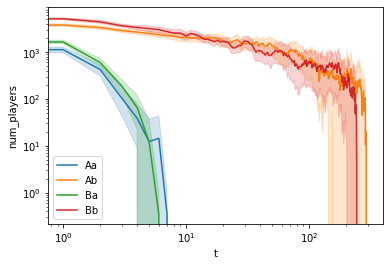

In [131]:
g = sns.lineplot(x='i', y='num_players', data=propAa)
sns.lineplot(x='i', y='num_players', data=propAb)
sns.lineplot(x='i', y='num_players', data=propBa)
sns.lineplot(x='i', y='num_players', data=propBb)
g.set_yscale("log")
g.set_xscale("log")
g.legend(['Aa', 'Ab', 'Ba', 'Bb'])
g.set(xlabel='t')

plt.savefig('../figures/brexit.pdf', format='pdf', dpi=1200)

## abortion

In [63]:
# load seeds
ABORTION_PATH = path.join(DATASETS_PATH, 'abortion')
A = [l.strip() for l in open(path.join(ABORTION_PATH, "side1_seeds.txt")).readlines()]  # A = pro abortion
B = [l.strip() for l in open(path.join(ABORTION_PATH, "side2_seeds.txt")).readlines()]  # B = anti abortion
len(A), len(B)

(52, 65)

In [64]:
# load probabilities
df = pd.read_csv(path.join(ABORTION_PATH, "abortion_network_heterogeneous.txt"),
                 sep='\t', names=['User', 'Follower', 'Pa', 'Pb'])
df

,User,Follower,Pa,Pb
0,01mbthebest,cindyselander87,2.000000e-08,2.000000e-08
1,01mbthebest,ghhshirley,1.600020e-03,2.000000e-08
2,01mbthebest,xxhowling4uxx,2.000000e-08,2.000000e-08
3,01mbthebest,shampreemarie23,2.000000e-08,2.000000e-08
4,01mbthebest,diamondsntears,2.000000e-08,2.000000e-08
...,...,...,...,...
671139,pplouisiana,liprap,4.800200e-04,2.000000e-08
671140,pplouisiana,bobocek,2.000000e-08,2.000000e-08
671141,pplouisiana,cecilerichards,2.752002e-02,2.000000e-08
671142,pplouisiana,robinmarty,8.000200e-04,1.280020e-03


In [65]:
((df.groupby('Follower')
    .std().dropna() > 0).value_counts(normalize=True)
                        .rename("% std > 0")
                        .reset_index())

,Pa,Pb,% std > 0
0,False,False,0.954701
1,True,True,0.045299


95% of the followers have the same probability of sharing across all the people they follow.

### Homophily

We measure homophily by estimating the probabilities that a user that belongs to group $g$ follows a user in group $g'$. This is very close to our replacement model because if $u_1$ shares content, it gives the opportunity to $u_2$ (the follower) to retweet the content.

In [66]:
# membership
labeled = df[(df.User.isin(A) | df.User.isin(B)) & (df.Follower.isin(A) | df.Follower.isin(B))].copy()
labeled['Group1'] = labeled.User.isin(A).replace({True: 'A', False: 'B'})
labeled['Group2'] = labeled.Follower.isin(A).replace({True: 'A', False: 'B'})
labeled.head()

,User,Follower,Pa,Pb,Group1,Group2
2908,365days4choice,saynsumthn,8.800020e-03,0.08,A,B
2909,365days4choice,prolifeamerica,1.968002e-02,0.08,A,B
2912,365days4choice,rockforlife,9.920020e-03,0.08,A,B
2914,365days4choice,inspirelifenow,6.400200e-04,0.08,A,B
2921,365days4choice,dailymass,2.000000e-08,0.08,A,B


In [67]:
labeled.Group1.value_counts(normalize=True).rename("$\\pi$").reset_index()

,index,$\pi$
0,B,0.627787
1,A,0.372213



To estimate the $q$ probabilities we just count the number of edges for each combination of groups and calculate group frequencies.

In [68]:
# replacement counts
replacements = (labeled.groupby(['Group1', 'Group2']).User
                       .count()
                       .unstack(fill_value=0)
                       .stack()
                       .rename('Counts')
                       .reset_index()
                       .set_index(['Group1', 'Group2']))
replacements

Counts
Group1 Group2        
A      A          120
       B           97
B      A           67
       B          299

In [69]:
# group1 counts
groups = (labeled.groupby('Group1').User
                 .count()
                 .rename('Counts')
                 .reset_index()
                 .set_index('Group1'))
groups

,Counts
Group1,
A,217
B,366


In [70]:
qs = (replacements / groups).rename(columns={'Counts': 'Frequency ($q$)'})
qs

Frequency ($q$)
Group1 Group2                 
A      A              0.552995
       B              0.447005
B      A              0.183060
       B              0.816940

Much higher homophily in the anti-abortion group.

The following is the homophily matrix (coordinates are the $q_A$, $1-q_A$, and 1- $q_B$, $q_B$ probabilities):

In [71]:
qs.unstack().values

array([[0.55299539, 0.44700461],
       [0.18306011, 0.81693989]])

### Share probability distributions


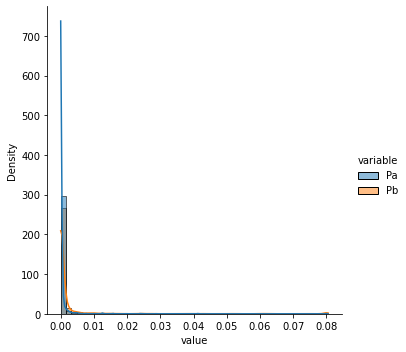

In [72]:
sns.displot(data=pd.melt(df,
                         id_vars=['User', 'Follower'],
                         value_vars=['Pa', 'Pb']),
            x='value',
            hue='variable',
            bins=50, kde=True, stat='density')

In [73]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a1, b1, loc1, scale1 = beta.fit(df.Pa, floc=0, fscale=1)
a1, b1

(0.1137200835502833, 232.2413782063585)

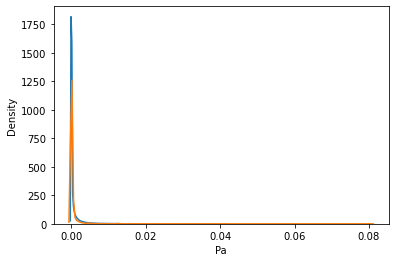

In [74]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=df.Pa.shape[0]))
sns.kdeplot(df.Pa)

In [75]:
# MLE estimates for the parameters of the beta distribution (for p_B)
a2, b2, loc2, scale2 = beta.fit(df.Pb, floc=0, fscale=1)
a2, b2

(0.10895218237266695, 39.9591062430043)

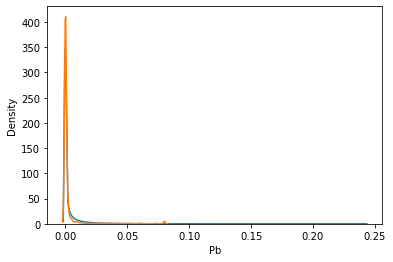

In [76]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=df.Pb.shape[0]))
sns.kdeplot(df.Pb)

The probabilities above are the conditional probabilities on a given initiator. In the data we see that the probability of sharing is independent of the initiator. That's strange because, in practice, since reputation and credibility are important factors for sharing someone else's tweet.

### Different groups

In [77]:
dfg = df[df.Follower.isin(B) | df.Follower.isin(A)]  # we just care about the group of the user who is retweeting

In [78]:
group = dfg.Follower.isin(A).replace({True: 'A', False: 'B'})

In [79]:
dfg.groupby(group).Follower.count()

Follower
A    2886
B    5253
Name: Follower, dtype: int64

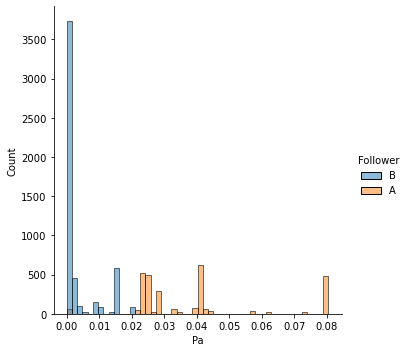

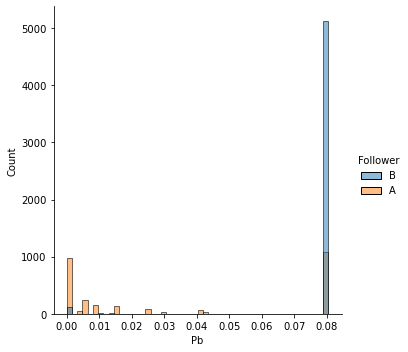

In [80]:
sns.displot(data=dfg, x='Pa', hue=group, bins=50)
sns.displot(data=dfg, x='Pb', hue=group, bins=50)

#### Fitting the distribution of $p_{A,a}$

In [81]:
# MLE estimates for the parameters of the beta distribution (for $p_{A,a}$)
a1, b1, loc1, scale1 = beta.fit(dfg[group == 'A'].Pa, floc=0, fscale=1)
a1, b1

(2.1955994970845176, 53.70406773206235)

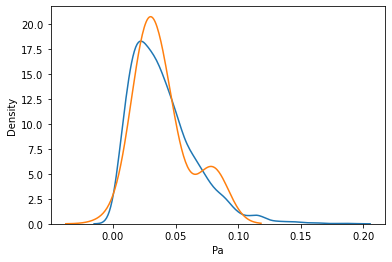

In [82]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=dfg[group == 'A'].Pa.shape[0]))
sns.kdeplot(dfg[group == 'A'].Pa, bw_adjust=3)

#### Fitting the distribution of $p_{A,b}$

In [83]:
a2, b2, loc2, scale2 = beta.fit(dfg[group == 'A'].Pb, floc=0, fscale=1)
a2, b2

(0.2547399546219493, 7.443199476254677)

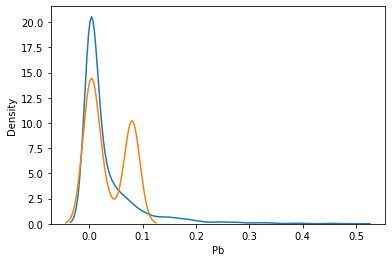

In [84]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=dfg[group == 'A'].Pb.shape[0]))
sns.kdeplot(dfg[group == 'A'].Pb, bw_adjust=2)

#### Fitting the distribution of $p_{B,a}$

In [85]:
a3, b3, loc3, scale3 = beta.fit(dfg[group == 'B'].Pa, floc=0, fscale=1)
a3, b3

(0.15985328765176798, 50.82834553323337)

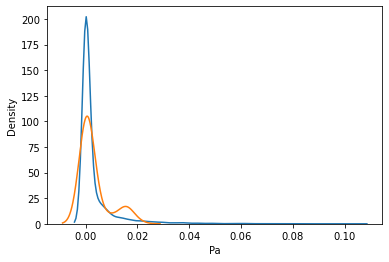

In [86]:
sns.kdeplot(np.random.beta(a=a3, b=b3, size=dfg[group == 'B'].Pa.shape[0]))
sns.kdeplot(dfg[group == 'B'].Pa, bw_adjust=3)

#### Fitting the distribution of $p_{B,b}$

In [87]:
a4, b4, loc4, scale4 = beta.fit(dfg[group == 'B'].Pb, floc=0, fscale=1)
a4, b4

(2.2966486101771286, 27.58967380064497)

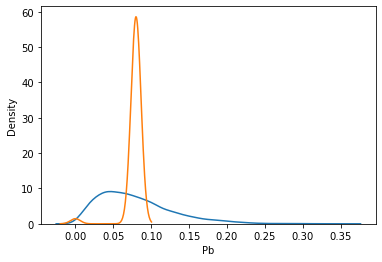

In [88]:
sns.kdeplot(np.random.beta(a=a4, b=b4, size=dfg[group == 'B'].Pb.shape[0]))
sns.kdeplot(dfg[group == 'B'].Pb, bw_adjust=3)

The data distributions seem strongly bimodal. I am not sure the beta is a good fit here.

## Propagation of the articles

In [89]:
cols = ['k', 'i', 'num_players']

# measure propagation of article a among A
propAa = pd.DataFrame(propagate(A, article='a'), columns=cols)

# measure propagation of article b among B
propBb = pd.DataFrame(propagate(B, article='b'), columns=cols)

# measure propagation of article b among A
propAb = pd.DataFrame(propagate(A, article='b'), columns=cols)

# measure propagation of article a among B
propBa = pd.DataFrame(propagate(B, article='a'), columns=cols)

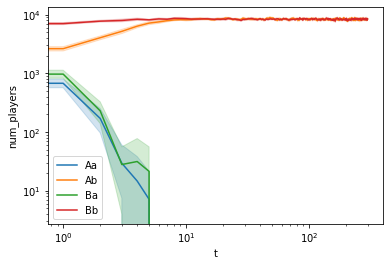

In [90]:
g = sns.lineplot(x='i', y='num_players', data=propAa)
sns.lineplot(x='i', y='num_players', data=propAb)
sns.lineplot(x='i', y='num_players', data=propBa)
sns.lineplot(x='i', y='num_players', data=propBb)
g.set_yscale("log")
g.set_xscale("log")
g.legend(['Aa', 'Ab', 'Ba', 'Bb'])
g.set(xlabel='t')

plt.savefig('../figures/abortion.pdf', format='pdf', dpi=1200)

## obamacare

In [91]:
# load seeds
OBAMACARE_PATH = path.join(DATASETS_PATH, 'obamacare')
A = [l.strip() for l in open(path.join(OBAMACARE_PATH, "side1_seeds.txt")).readlines()]  # A = pro
B = [l.strip() for l in open(path.join(OBAMACARE_PATH, "side2_seeds.txt")).readlines()]  # B = anti
len(A), len(B)

(72, 78)

In [92]:
# load probabilities
df = pd.read_csv(path.join(OBAMACARE_PATH, "obamacare_network_heterogeneous.txt"),
                 sep='\t', names=['User', 'Follower', 'Pa', 'Pb'])
df

,User,Follower,Pa,Pb
0,00_jackie,markinnorcal,2.000000e-08,2.000000e-08
1,00_jackie,sluggod54,7.768990e-05,7.768990e-05
2,00_jackie,redrivergrl,1.600200e-04,5.440020e-03
3,00_jackie,instotus,2.000000e-08,2.000000e-08
4,00_jackie,mainearmy,1.156269e-04,1.156269e-04
...,...,...,...,...
1511665,drvtorresm,digisistemas,2.000000e-08,2.000000e-08
1511666,drvtorresm,verkaufermx,2.000000e-08,2.000000e-08
1511667,bondedservant,gaypatriot,2.000000e-08,1.600200e-04
1511668,bondedservant,mcgeeservice,2.000000e-08,2.000000e-08


In [93]:
((df.groupby('Follower')
    .std().dropna() > 0).value_counts(normalize=True)
                        .rename("% std > 0")
                        .reset_index())

,Pa,Pb,% std > 0
0,False,False,0.609643
1,True,True,0.390357


60% of the followers have the same probability of sharing across all the people they follow.

### Issues with the dataset

The dataset has probabilities values that are greater than 1!? This really looks like an error in the way they calculated the probabilities of the heterogeneous dataset. The probabilities are within range for the correlated dataset.

In [94]:
df[(df.Pa > 1) | (df.Pb > 1)].head()

,User,Follower,Pa,Pb
36323,arifansfc,aridiazz,7.100000,7.100000
104888,vaskenshamekian,jds_unt,1.700000,1.700000
104918,vaskenshamekian,partidount,2.700000,2.700000
171343,aliciadesotelo,_alexsotelo,1.164286,1.164286
177151,amzam,propublica,1.620000,1.620000


### Homophily

We measure homophily by estimating the probabilities that a user that belongs to group $g$ follows a user in group $g'$. This is very close to our replacement model because if $u_1$ shares content, it gives the opportunity to $u_2$ (the follower) to retweet the content.

In [95]:
# membership
labeled = df[(df.User.isin(A) | df.User.isin(B)) & (df.Follower.isin(A) | df.Follower.isin(B))].copy()
labeled['Group1'] = labeled.User.isin(A).replace({True: 'A', False: 'B'})
labeled['Group2'] = labeled.Follower.isin(A).replace({True: 'A', False: 'B'})
labeled.head()

,User,Follower,Pa,Pb,Group1,Group2
4935,196alicia,laureldavilacpa,0.03296,2.000000e-08,A,A
4937,196alicia,gus70romero,0.03472,2.000000e-08,A,A
4944,196alicia,monteros797,0.04064,2.000000e-08,A,A
4950,196alicia,adria_ra,0.04272,2.000000e-08,A,A
4952,196alicia,crishely2008cc,0.03648,2.000000e-08,A,A


In [96]:
labeled.Group1.value_counts(normalize=True).rename("$\\pi$").reset_index()

,index,$\pi$
0,A,0.602601
1,B,0.397399


Size difference between groups is larger than in other datasets.

To estimate the $q$ probabilities we just count the number of edges for each combination of groups and calculate group frequencies.

In [97]:
# replacement counts
replacements = (labeled.groupby(['Group1', 'Group2']).User
                       .count()
                       .unstack(fill_value=0)
                       .stack()
                       .rename('Counts')
                       .reset_index()
                       .set_index(['Group1', 'Group2']))
replacements

Counts
Group1 Group2        
A      A          370
       B           47
B      A           90
       B          185

In [98]:
# group1 counts
groups = (labeled.groupby('Group1').User
                 .count()
                 .rename('Counts')
                 .reset_index()
                 .set_index('Group1'))
groups

,Counts
Group1,
A,417
B,275


In [99]:
qs = (replacements / groups).rename(columns={'Counts': 'Frequency ($q$)'})
qs

Frequency ($q$)
Group1 Group2                 
A      A              0.887290
       B              0.112710
B      A              0.327273
       B              0.672727

Much higher homophily in the anti-abortion group.

The following is the homophily matrix (coordinates are the $q_A$, $1-q_A$, and 1- $q_B$, $q_B$ probabilities):

In [100]:
qs.unstack().values

array([[0.88729017, 0.11270983],
       [0.32727273, 0.67272727]])